In [1]:
!pip install momentfm

  Using cached momentfm-0.1.1-py3-none-any.whl.metadata (15 kB)
  Using cached huggingface_hub-0.19.4-py3-none-any.whl.metadata (14 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 33.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 751.2/751.2 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.5/776.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.6 MB/s eta 0:00:0000:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.0
    Uninstalling numpy-2.1.0:
      Successfully uninstalled numpy-2.1.0


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from momentfm import MOMENTPipeline
from pprint import pprint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.cuda.amp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm
from momentfm.utils.utils import control_randomness
from momentfm.data.informer_dataset import InformerDataset
from momentfm.utils.forecasting_metrics import get_forecasting_metrics
import warnings
warnings.filterwarnings('ignore')
# Set random seeds for PyTorch, Numpy etc.
control_randomness(seed=13) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [5]:
df = pd.read_csv('data_final/combined_data.csv')
train_df = df[df['set'] == 'train']
train_df.drop(columns=['set'], inplace=True)
test_df = df[df['set'] == 'test']
test_df.drop(columns=['set'], inplace=True)

In [6]:
train_df_no_date = train_df.drop(columns=['Date'])
test_df_no_date = test_df.drop(columns=['Date'])

In [7]:
# create a train and test dataloader for forecasting H days ahead
H = 21
class TimeSeriesDataset(Dataset):
    def __init__(self, timeseries, H, fixed_length=512):
        self.timeseries = timeseries
        self.H = H
        self.fixed_length = fixed_length

        if len(self.timeseries.shape) == 1:
            # If the time series shape [n], reshape it to [1, n]
            self.timeseries = self.timeseries.reshape(1, -1)
                    
    def __len__(self):
        # Ensure that we don't go out of bounds
        return self.timeseries.shape[0] - self.H

    def __getitem__(self, idx):
        # Input: time series from the start up to idx+1
        start_idx = max(0, idx + 1 - self.fixed_length)
        input_series = self.timeseries[start_idx:idx + 1]
        
        # Padding: pad input_series to fixed_length with zeros on the left
        pad_len = self.fixed_length - input_series.shape[0]
        input_series = np.pad(input_series, ((pad_len, 0), (0, 0)), mode='constant')
        # input_series is [fixed_length, n_features], I need it in [n_features, fixed_length]
        input_series = input_series.T
        
        # Mask: 1s for the values we have, 0s for the values we don't have
        mask = np.ones(self.fixed_length)
        mask[:pad_len] = 0
        
        # Label: next H values after idx
        label = self.timeseries[idx + 1: idx + 1 + self.H]
        label = np.array(label).T
        
        return torch.tensor(input_series, dtype=torch.float32), torch.tensor(label, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

In [9]:
train_dataset = TimeSeriesDataset(train_df_no_date, H)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = TimeSeriesDataset(test_df_no_date, H)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [10]:
for values in train_loader:
    print(f'values: {values[0].shape}')
    break

values: torch.Size([8, 6, 512])


# MOMENT

In [11]:
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': H,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True, # Freeze the patch embedding layer
        'freeze_embedder': True, # Freeze the transformer encoder
        'freeze_head': False, # The linear forecasting head must be trained
    },
    # local_files_only=True,  # Whether or not to only look at local files (i.e., do not try to download the model).
)

config.json: 100%|██████████| 951/951 [00:00<00:00, 1.49MB/s]
pytorch_model.bin: 100%|██████████| 1.39G/1.39G [00:29<00:00, 47.2MB/s]


In [12]:
model.init()
print("Unfrozen parameters:")
for name, param in model.named_parameters():    
    if param.requires_grad:
        print('    ', name)

Unfrozen parameters:
     head.linear.weight
     head.linear.bias


## Fine-tuning the model using the training data

In [32]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

cur_epoch = 0
max_epoch = 100

# Move the model to the GPU
model = model.to(device)

# Move the loss function to the GPU
criterion = criterion.to(device)

# Enable mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Create a OneCycleLR scheduler
max_lr = 1e-4
total_steps = len(train_loader) * max_epoch
scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.3)

# Gradient clipping value
max_norm = 5.0
test_mse_per_epoch = []
test_mae_per_epoch = []
while cur_epoch < max_epoch:
    losses = []
    for timeseries, forecast, input_mask in tqdm(train_loader, total=len(train_loader)):
        # Move the data to the GPU
        timeseries = timeseries.float().to(device)
        input_mask = input_mask.to(device)
        forecast = forecast.float().to(device)

        with torch.cuda.amp.autocast():
            output = model(timeseries, input_mask)
        
        loss = criterion(output.forecast, forecast)

        # Scales the loss for mixed precision training
        scaler.scale(loss).backward()

        # Clip gradients
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        losses.append(loss.item())

    losses = np.array(losses)
    average_loss = np.average(losses)
    print(f"Epoch {cur_epoch}: Train loss: {average_loss:.3f}")

    # Step the learning rate scheduler
    scheduler.step()
    cur_epoch += 1
    
    # Evaluate the model on the test split
    trues, preds, histories, losses = [], [], [], []
    model.eval()
    with torch.no_grad():
        for timeseries, forecast, input_mask in tqdm(test_loader, total=len(test_loader)):
        # Move the data to the GPU
            timeseries = timeseries.float().to(device)
            input_mask = input_mask.to(device)
            forecast = forecast.float().to(device)

            with torch.cuda.amp.autocast():
                output = model(timeseries, input_mask)
            
            loss = criterion(output.forecast, forecast)                
            losses.append(loss.item())

            trues.append(forecast.detach().cpu().numpy())
            preds.append(output.forecast.detach().cpu().numpy())
            histories.append(timeseries.detach().cpu().numpy())
    
    losses = np.array(losses)
    average_loss = np.average(losses)
    model.train()

    trues = np.concatenate(trues, axis=0)
    preds = np.concatenate(preds, axis=0)
    histories = np.concatenate(histories, axis=0)
    
    metrics = get_forecasting_metrics(y=trues, y_hat=preds, reduction='mean')

    print(f"Epoch {cur_epoch}: Test MSE: {metrics.mse:.3f} | Test MAE: {metrics.mae:.3f}")
    test_mse_per_epoch.append(metrics.mse)
    test_mae_per_epoch.append(metrics.mae)

100%|██████████| 156/156 [00:06<00:00, 25.21it/s]


Epoch 0: Train loss: 354801.339


100%|██████████| 103/103 [00:03<00:00, 27.77it/s]


Epoch 1: Test MSE: 568110.812 | Test MAE: 300.669


100%|██████████| 156/156 [00:06<00:00, 25.72it/s]


Epoch 1: Train loss: 356150.550


100%|██████████| 103/103 [00:03<00:00, 27.72it/s]


Epoch 2: Test MSE: 565426.500 | Test MAE: 299.791


100%|██████████| 156/156 [00:06<00:00, 25.79it/s]


Epoch 2: Train loss: 350646.296


100%|██████████| 103/103 [00:03<00:00, 27.58it/s]


Epoch 3: Test MSE: 555564.562 | Test MAE: 296.417


100%|██████████| 156/156 [00:06<00:00, 25.75it/s]


Epoch 3: Train loss: 353172.788


100%|██████████| 103/103 [00:03<00:00, 27.56it/s]


Epoch 4: Test MSE: 568890.562 | Test MAE: 301.460


100%|██████████| 156/156 [00:06<00:00, 25.67it/s]


Epoch 4: Train loss: 338071.618


100%|██████████| 103/103 [00:03<00:00, 27.48it/s]


Epoch 5: Test MSE: 549938.562 | Test MAE: 295.389


100%|██████████| 156/156 [00:06<00:00, 25.68it/s]


Epoch 5: Train loss: 328726.166


100%|██████████| 103/103 [00:03<00:00, 27.43it/s]


Epoch 6: Test MSE: 556951.688 | Test MAE: 297.204


100%|██████████| 156/156 [00:06<00:00, 25.60it/s]


Epoch 6: Train loss: 347973.895


100%|██████████| 103/103 [00:03<00:00, 27.40it/s]


Epoch 7: Test MSE: 551764.938 | Test MAE: 296.505


100%|██████████| 156/156 [00:06<00:00, 25.57it/s]


Epoch 7: Train loss: 335859.276


100%|██████████| 103/103 [00:03<00:00, 27.45it/s]


Epoch 8: Test MSE: 562759.438 | Test MAE: 302.096


100%|██████████| 156/156 [00:06<00:00, 25.43it/s]


Epoch 8: Train loss: 365479.343


100%|██████████| 103/103 [00:03<00:00, 27.42it/s]


Epoch 9: Test MSE: 543042.812 | Test MAE: 295.366


100%|██████████| 156/156 [00:06<00:00, 25.41it/s]


Epoch 9: Train loss: 348917.657


100%|██████████| 103/103 [00:03<00:00, 27.36it/s]


Epoch 10: Test MSE: 563169.562 | Test MAE: 302.780


100%|██████████| 156/156 [00:06<00:00, 25.48it/s]


Epoch 10: Train loss: 332868.464


100%|██████████| 103/103 [00:03<00:00, 27.27it/s]


Epoch 11: Test MSE: 557998.188 | Test MAE: 301.015


100%|██████████| 156/156 [00:06<00:00, 25.45it/s]


Epoch 11: Train loss: 362918.929


100%|██████████| 103/103 [00:03<00:00, 27.26it/s]


Epoch 12: Test MSE: 544874.938 | Test MAE: 295.857


100%|██████████| 156/156 [00:06<00:00, 25.46it/s]


Epoch 12: Train loss: 327502.885


100%|██████████| 103/103 [00:03<00:00, 27.21it/s]


Epoch 13: Test MSE: 549589.125 | Test MAE: 297.895


100%|██████████| 156/156 [00:06<00:00, 25.43it/s]


Epoch 13: Train loss: 335383.013


100%|██████████| 103/103 [00:03<00:00, 27.20it/s]


Epoch 14: Test MSE: 554629.688 | Test MAE: 299.703


100%|██████████| 156/156 [00:06<00:00, 25.39it/s]


Epoch 14: Train loss: 348410.493


100%|██████████| 103/103 [00:03<00:00, 27.16it/s]


Epoch 15: Test MSE: 541374.562 | Test MAE: 294.801


100%|██████████| 156/156 [00:06<00:00, 25.39it/s]


Epoch 15: Train loss: 338624.323


100%|██████████| 103/103 [00:03<00:00, 27.16it/s]


Epoch 16: Test MSE: 542458.000 | Test MAE: 295.883


100%|██████████| 156/156 [00:06<00:00, 25.39it/s]


Epoch 16: Train loss: 327237.126


100%|██████████| 103/103 [00:03<00:00, 27.19it/s]


Epoch 17: Test MSE: 546446.438 | Test MAE: 297.538


100%|██████████| 156/156 [00:06<00:00, 25.39it/s]


Epoch 17: Train loss: 338164.316


100%|██████████| 103/103 [00:03<00:00, 27.13it/s]


Epoch 18: Test MSE: 539917.938 | Test MAE: 295.579


100%|██████████| 156/156 [00:06<00:00, 25.37it/s]


Epoch 18: Train loss: 332724.383


100%|██████████| 103/103 [00:03<00:00, 27.22it/s]


Epoch 19: Test MSE: 546258.000 | Test MAE: 297.824


100%|██████████| 156/156 [00:06<00:00, 25.23it/s]


Epoch 19: Train loss: 341990.071


100%|██████████| 103/103 [00:03<00:00, 26.02it/s]


Epoch 20: Test MSE: 545785.750 | Test MAE: 297.950


100%|██████████| 156/156 [00:06<00:00, 25.27it/s]


Epoch 20: Train loss: 312190.911


100%|██████████| 103/103 [00:03<00:00, 27.15it/s]


Epoch 21: Test MSE: 526752.688 | Test MAE: 291.932


100%|██████████| 156/156 [00:06<00:00, 25.20it/s]


Epoch 21: Train loss: 344455.475


100%|██████████| 103/103 [00:03<00:00, 27.17it/s]


Epoch 22: Test MSE: 550100.500 | Test MAE: 299.893


100%|██████████| 156/156 [00:06<00:00, 25.36it/s]


Epoch 22: Train loss: 328405.319


100%|██████████| 103/103 [00:03<00:00, 27.10it/s]


Epoch 23: Test MSE: 546292.938 | Test MAE: 299.066


100%|██████████| 156/156 [00:06<00:00, 25.31it/s]


Epoch 23: Train loss: 333525.011


100%|██████████| 103/103 [00:03<00:00, 27.10it/s]


Epoch 24: Test MSE: 546904.500 | Test MAE: 299.762


100%|██████████| 156/156 [00:06<00:00, 25.31it/s]


Epoch 24: Train loss: 329853.412


100%|██████████| 103/103 [00:03<00:00, 27.11it/s]


Epoch 25: Test MSE: 539390.438 | Test MAE: 298.225


100%|██████████| 156/156 [00:06<00:00, 25.33it/s]


Epoch 25: Train loss: 319818.654


100%|██████████| 103/103 [00:03<00:00, 27.07it/s]


Epoch 26: Test MSE: 532590.188 | Test MAE: 294.679


100%|██████████| 156/156 [00:06<00:00, 25.28it/s]


Epoch 26: Train loss: 357167.852


100%|██████████| 103/103 [00:03<00:00, 27.07it/s]


Epoch 27: Test MSE: 542751.062 | Test MAE: 298.340


100%|██████████| 156/156 [00:06<00:00, 25.25it/s]


Epoch 27: Train loss: 326855.932


100%|██████████| 103/103 [00:03<00:00, 27.08it/s]


Epoch 28: Test MSE: 536918.438 | Test MAE: 297.459


100%|██████████| 156/156 [00:06<00:00, 25.30it/s]


Epoch 28: Train loss: 338238.065


100%|██████████| 103/103 [00:03<00:00, 27.06it/s]


Epoch 29: Test MSE: 547716.312 | Test MAE: 301.704


100%|██████████| 156/156 [00:06<00:00, 25.31it/s]


Epoch 29: Train loss: 333515.207


100%|██████████| 103/103 [00:03<00:00, 27.07it/s]


Epoch 30: Test MSE: 525704.875 | Test MAE: 293.944


100%|██████████| 156/156 [00:06<00:00, 25.24it/s]


Epoch 30: Train loss: 361958.150


100%|██████████| 103/103 [00:03<00:00, 27.06it/s]


Epoch 31: Test MSE: 534605.375 | Test MAE: 297.777


100%|██████████| 156/156 [00:06<00:00, 25.26it/s]


Epoch 31: Train loss: 327105.272


100%|██████████| 103/103 [00:03<00:00, 27.03it/s]


Epoch 32: Test MSE: 557201.438 | Test MAE: 305.433


100%|██████████| 156/156 [00:06<00:00, 25.22it/s]


Epoch 32: Train loss: 333758.672


100%|██████████| 103/103 [00:03<00:00, 27.13it/s]


Epoch 33: Test MSE: 541284.062 | Test MAE: 299.055


100%|██████████| 156/156 [00:06<00:00, 24.56it/s]


Epoch 33: Train loss: 312270.799


100%|██████████| 103/103 [00:03<00:00, 27.14it/s]


Epoch 34: Test MSE: 536606.562 | Test MAE: 298.826


100%|██████████| 156/156 [00:06<00:00, 25.15it/s]


Epoch 34: Train loss: 329450.099


100%|██████████| 103/103 [00:03<00:00, 27.12it/s]


Epoch 35: Test MSE: 531726.375 | Test MAE: 296.614


100%|██████████| 156/156 [00:06<00:00, 25.18it/s]


Epoch 35: Train loss: 334957.871


100%|██████████| 103/103 [00:03<00:00, 27.13it/s]


Epoch 36: Test MSE: 533111.938 | Test MAE: 298.961


100%|██████████| 156/156 [00:06<00:00, 25.15it/s]


Epoch 36: Train loss: 333121.341


100%|██████████| 103/103 [00:03<00:00, 27.05it/s]


Epoch 37: Test MSE: 528911.500 | Test MAE: 296.939


100%|██████████| 156/156 [00:06<00:00, 25.25it/s]


Epoch 37: Train loss: 320406.834


100%|██████████| 103/103 [00:03<00:00, 27.05it/s]


Epoch 38: Test MSE: 537845.188 | Test MAE: 300.393


100%|██████████| 156/156 [00:06<00:00, 25.25it/s]


Epoch 38: Train loss: 325398.854


100%|██████████| 103/103 [00:03<00:00, 27.03it/s]


Epoch 39: Test MSE: 550705.188 | Test MAE: 305.474


100%|██████████| 156/156 [00:06<00:00, 25.26it/s]


Epoch 39: Train loss: 326198.600


100%|██████████| 103/103 [00:03<00:00, 27.06it/s]


Epoch 40: Test MSE: 528959.250 | Test MAE: 296.976


100%|██████████| 156/156 [00:06<00:00, 25.26it/s]


Epoch 40: Train loss: 333365.054


100%|██████████| 103/103 [00:03<00:00, 27.06it/s]


Epoch 41: Test MSE: 543226.750 | Test MAE: 301.630


100%|██████████| 156/156 [00:06<00:00, 25.26it/s]


Epoch 41: Train loss: 322810.448


100%|██████████| 103/103 [00:03<00:00, 27.03it/s]


Epoch 42: Test MSE: 540888.312 | Test MAE: 301.066


100%|██████████| 156/156 [00:06<00:00, 25.22it/s]


Epoch 42: Train loss: 327727.774


100%|██████████| 103/103 [00:03<00:00, 27.05it/s]


Epoch 43: Test MSE: 531059.312 | Test MAE: 298.418


100%|██████████| 156/156 [00:06<00:00, 25.23it/s]


Epoch 43: Train loss: 333533.517


100%|██████████| 103/103 [00:03<00:00, 25.84it/s]


Epoch 44: Test MSE: 533155.500 | Test MAE: 298.999


100%|██████████| 156/156 [00:06<00:00, 25.20it/s]


Epoch 44: Train loss: 332134.930


100%|██████████| 103/103 [00:03<00:00, 27.05it/s]


Epoch 45: Test MSE: 539543.438 | Test MAE: 302.529


100%|██████████| 156/156 [00:06<00:00, 25.27it/s]


Epoch 45: Train loss: 303979.746


100%|██████████| 103/103 [00:03<00:00, 27.01it/s]


Epoch 46: Test MSE: 540657.062 | Test MAE: 302.328


100%|██████████| 156/156 [00:06<00:00, 25.23it/s]


Epoch 46: Train loss: 323438.581


100%|██████████| 103/103 [00:03<00:00, 27.02it/s]


Epoch 47: Test MSE: 543919.500 | Test MAE: 304.889


100%|██████████| 156/156 [00:06<00:00, 25.23it/s]


Epoch 47: Train loss: 329903.154


100%|██████████| 103/103 [00:03<00:00, 26.98it/s]


Epoch 48: Test MSE: 547364.188 | Test MAE: 306.400


100%|██████████| 156/156 [00:06<00:00, 25.26it/s]


Epoch 48: Train loss: 330366.368


100%|██████████| 103/103 [00:03<00:00, 26.98it/s]


Epoch 49: Test MSE: 541759.125 | Test MAE: 304.065


100%|██████████| 156/156 [00:06<00:00, 25.28it/s]


Epoch 49: Train loss: 315131.857


100%|██████████| 103/103 [00:03<00:00, 27.05it/s]


Epoch 50: Test MSE: 527234.562 | Test MAE: 298.453


100%|██████████| 156/156 [00:06<00:00, 25.22it/s]


Epoch 50: Train loss: 326541.069


100%|██████████| 103/103 [00:03<00:00, 27.09it/s]


Epoch 51: Test MSE: 532166.938 | Test MAE: 300.414


100%|██████████| 156/156 [00:06<00:00, 25.10it/s]


Epoch 51: Train loss: 317691.919


100%|██████████| 103/103 [00:03<00:00, 27.09it/s]


Epoch 52: Test MSE: 528563.938 | Test MAE: 298.986


100%|██████████| 156/156 [00:06<00:00, 25.13it/s]


Epoch 52: Train loss: 324708.054


100%|██████████| 103/103 [00:03<00:00, 27.08it/s]


Epoch 53: Test MSE: 543295.750 | Test MAE: 304.958


100%|██████████| 156/156 [00:06<00:00, 25.12it/s]


Epoch 53: Train loss: 308898.899


100%|██████████| 103/103 [00:03<00:00, 27.07it/s]


Epoch 54: Test MSE: 511104.031 | Test MAE: 293.572


100%|██████████| 156/156 [00:06<00:00, 24.55it/s]


Epoch 54: Train loss: 321313.965


100%|██████████| 103/103 [00:03<00:00, 27.09it/s]


Epoch 55: Test MSE: 521397.906 | Test MAE: 296.922


100%|██████████| 156/156 [00:06<00:00, 25.11it/s]


Epoch 55: Train loss: 312522.017


100%|██████████| 103/103 [00:03<00:00, 27.09it/s]


Epoch 56: Test MSE: 532422.438 | Test MAE: 301.830


100%|██████████| 156/156 [00:06<00:00, 25.18it/s]


Epoch 56: Train loss: 326857.580


100%|██████████| 103/103 [00:03<00:00, 27.05it/s]


Epoch 57: Test MSE: 526682.812 | Test MAE: 299.937


100%|██████████| 156/156 [00:06<00:00, 25.22it/s]


Epoch 57: Train loss: 318406.678


100%|██████████| 103/103 [00:03<00:00, 27.02it/s]


Epoch 58: Test MSE: 535968.250 | Test MAE: 303.837


100%|██████████| 156/156 [00:06<00:00, 25.23it/s]


Epoch 58: Train loss: 332511.743


100%|██████████| 103/103 [00:03<00:00, 26.97it/s]


Epoch 59: Test MSE: 533122.312 | Test MAE: 302.005


100%|██████████| 156/156 [00:06<00:00, 25.22it/s]


Epoch 59: Train loss: 309455.480


100%|██████████| 103/103 [00:03<00:00, 27.04it/s]


Epoch 60: Test MSE: 540766.938 | Test MAE: 305.496


100%|██████████| 156/156 [00:06<00:00, 25.24it/s]


Epoch 60: Train loss: 304704.280


100%|██████████| 103/103 [00:03<00:00, 27.04it/s]


Epoch 61: Test MSE: 534836.938 | Test MAE: 303.459


100%|██████████| 156/156 [00:06<00:00, 25.21it/s]


Epoch 61: Train loss: 306562.553


100%|██████████| 103/103 [00:03<00:00, 27.04it/s]


Epoch 62: Test MSE: 536703.438 | Test MAE: 303.870


100%|██████████| 156/156 [00:06<00:00, 25.21it/s]


Epoch 62: Train loss: 316515.895


100%|██████████| 103/103 [00:03<00:00, 27.01it/s]


Epoch 63: Test MSE: 529456.500 | Test MAE: 301.681


100%|██████████| 156/156 [00:06<00:00, 25.19it/s]


Epoch 63: Train loss: 305209.871


100%|██████████| 103/103 [00:03<00:00, 27.02it/s]


Epoch 64: Test MSE: 534015.938 | Test MAE: 303.506


100%|██████████| 156/156 [00:06<00:00, 25.24it/s]


Epoch 64: Train loss: 321303.858


100%|██████████| 103/103 [00:03<00:00, 26.15it/s]


Epoch 65: Test MSE: 538719.562 | Test MAE: 305.383


100%|██████████| 156/156 [00:06<00:00, 25.18it/s]


Epoch 65: Train loss: 315833.230


100%|██████████| 103/103 [00:03<00:00, 27.04it/s]


Epoch 66: Test MSE: 530477.750 | Test MAE: 302.359


100%|██████████| 156/156 [00:06<00:00, 25.23it/s]


Epoch 66: Train loss: 331228.080


100%|██████████| 103/103 [00:03<00:00, 27.04it/s]


Epoch 67: Test MSE: 529302.125 | Test MAE: 302.697


100%|██████████| 156/156 [00:06<00:00, 25.22it/s]


Epoch 67: Train loss: 328049.763


100%|██████████| 103/103 [00:03<00:00, 27.02it/s]


Epoch 68: Test MSE: 530830.500 | Test MAE: 302.557


100%|██████████| 156/156 [00:06<00:00, 25.25it/s]


Epoch 68: Train loss: 337924.456


100%|██████████| 103/103 [00:03<00:00, 27.04it/s]


Epoch 69: Test MSE: 534125.375 | Test MAE: 303.973


100%|██████████| 156/156 [00:06<00:00, 25.24it/s]


Epoch 69: Train loss: 306859.471


100%|██████████| 103/103 [00:03<00:00, 27.03it/s]


Epoch 70: Test MSE: 524689.125 | Test MAE: 301.559


100%|██████████| 156/156 [00:06<00:00, 25.25it/s]


Epoch 70: Train loss: 320324.483


100%|██████████| 103/103 [00:03<00:00, 27.05it/s]


Epoch 71: Test MSE: 552374.438 | Test MAE: 312.278


100%|██████████| 156/156 [00:06<00:00, 25.18it/s]


Epoch 71: Train loss: 303283.751


100%|██████████| 103/103 [00:03<00:00, 27.03it/s]


Epoch 72: Test MSE: 527522.688 | Test MAE: 302.014


100%|██████████| 156/156 [00:06<00:00, 25.17it/s]


Epoch 72: Train loss: 315901.332


100%|██████████| 103/103 [00:03<00:00, 27.07it/s]


Epoch 73: Test MSE: 538526.625 | Test MAE: 305.168


100%|██████████| 156/156 [00:06<00:00, 25.16it/s]


Epoch 73: Train loss: 318856.810


100%|██████████| 103/103 [00:03<00:00, 27.11it/s]


Epoch 74: Test MSE: 540501.688 | Test MAE: 307.555


100%|██████████| 156/156 [00:06<00:00, 25.15it/s]


Epoch 74: Train loss: 320667.576


100%|██████████| 103/103 [00:03<00:00, 27.10it/s]


Epoch 75: Test MSE: 539389.125 | Test MAE: 307.645


100%|██████████| 156/156 [00:06<00:00, 25.15it/s]


Epoch 75: Train loss: 313914.232


100%|██████████| 103/103 [00:03<00:00, 27.10it/s]


Epoch 76: Test MSE: 538758.562 | Test MAE: 307.278


100%|██████████| 156/156 [00:06<00:00, 25.07it/s]


Epoch 76: Train loss: 318216.506


100%|██████████| 103/103 [00:03<00:00, 27.08it/s]


Epoch 77: Test MSE: 532418.375 | Test MAE: 304.675


100%|██████████| 156/156 [00:06<00:00, 25.15it/s]


Epoch 77: Train loss: 301058.622


100%|██████████| 103/103 [00:03<00:00, 27.04it/s]


Epoch 78: Test MSE: 524881.500 | Test MAE: 302.135


100%|██████████| 156/156 [00:06<00:00, 25.08it/s]


Epoch 78: Train loss: 332315.391


100%|██████████| 103/103 [00:03<00:00, 27.09it/s]


Epoch 79: Test MSE: 530296.500 | Test MAE: 305.138


100%|██████████| 156/156 [00:06<00:00, 25.28it/s]


Epoch 79: Train loss: 306580.692


100%|██████████| 103/103 [00:03<00:00, 27.06it/s]


Epoch 80: Test MSE: 542767.625 | Test MAE: 307.858


100%|██████████| 156/156 [00:06<00:00, 25.25it/s]


Epoch 80: Train loss: 322283.342


100%|██████████| 103/103 [00:03<00:00, 27.01it/s]


Epoch 81: Test MSE: 521950.312 | Test MAE: 301.232


100%|██████████| 156/156 [00:06<00:00, 25.27it/s]


Epoch 81: Train loss: 310889.084


100%|██████████| 103/103 [00:03<00:00, 27.06it/s]


Epoch 82: Test MSE: 518817.750 | Test MAE: 301.551


100%|██████████| 156/156 [00:06<00:00, 25.25it/s]


Epoch 82: Train loss: 315348.897


100%|██████████| 103/103 [00:03<00:00, 27.00it/s]


Epoch 83: Test MSE: 535022.562 | Test MAE: 306.688


100%|██████████| 156/156 [00:06<00:00, 25.20it/s]


Epoch 83: Train loss: 323959.724


100%|██████████| 103/103 [00:03<00:00, 27.00it/s]


Epoch 84: Test MSE: 513713.406 | Test MAE: 297.903


100%|██████████| 156/156 [00:06<00:00, 25.19it/s]


Epoch 84: Train loss: 315123.047


100%|██████████| 103/103 [00:03<00:00, 27.00it/s]


Epoch 85: Test MSE: 531269.438 | Test MAE: 304.640


100%|██████████| 156/156 [00:06<00:00, 25.23it/s]


Epoch 85: Train loss: 326564.372


100%|██████████| 103/103 [00:03<00:00, 27.04it/s]


Epoch 86: Test MSE: 523381.562 | Test MAE: 302.132


100%|██████████| 156/156 [00:06<00:00, 25.28it/s]


Epoch 86: Train loss: 327509.711


100%|██████████| 103/103 [00:03<00:00, 27.05it/s]


Epoch 87: Test MSE: 516890.125 | Test MAE: 299.691


100%|██████████| 156/156 [00:06<00:00, 25.19it/s]


Epoch 87: Train loss: 306267.807


100%|██████████| 103/103 [00:03<00:00, 27.02it/s]


Epoch 88: Test MSE: 510842.562 | Test MAE: 298.306


100%|██████████| 156/156 [00:06<00:00, 25.25it/s]


Epoch 88: Train loss: 315111.710


100%|██████████| 103/103 [00:03<00:00, 26.97it/s]


Epoch 89: Test MSE: 530122.625 | Test MAE: 305.258


100%|██████████| 156/156 [00:06<00:00, 25.23it/s]


Epoch 89: Train loss: 312350.734


100%|██████████| 103/103 [00:03<00:00, 27.04it/s]


Epoch 90: Test MSE: 518801.125 | Test MAE: 301.524


100%|██████████| 156/156 [00:06<00:00, 25.24it/s]


Epoch 90: Train loss: 321379.757


100%|██████████| 103/103 [00:03<00:00, 27.01it/s]


Epoch 91: Test MSE: 535139.438 | Test MAE: 308.391


100%|██████████| 156/156 [00:06<00:00, 25.23it/s]


Epoch 91: Train loss: 290248.019


100%|██████████| 103/103 [00:03<00:00, 27.02it/s]


Epoch 92: Test MSE: 530324.062 | Test MAE: 306.831


100%|██████████| 156/156 [00:06<00:00, 25.28it/s]


Epoch 92: Train loss: 304252.783


100%|██████████| 103/103 [00:03<00:00, 27.06it/s]


Epoch 93: Test MSE: 525782.750 | Test MAE: 304.227


100%|██████████| 156/156 [00:06<00:00, 25.24it/s]


Epoch 93: Train loss: 316001.065


100%|██████████| 103/103 [00:03<00:00, 27.03it/s]


Epoch 94: Test MSE: 532511.750 | Test MAE: 307.673


100%|██████████| 156/156 [00:06<00:00, 24.65it/s]


Epoch 94: Train loss: 306415.391


100%|██████████| 103/103 [00:03<00:00, 27.03it/s]


Epoch 95: Test MSE: 530552.625 | Test MAE: 306.117


100%|██████████| 156/156 [00:06<00:00, 25.25it/s]


Epoch 95: Train loss: 316609.183


100%|██████████| 103/103 [00:03<00:00, 27.02it/s]


Epoch 96: Test MSE: 538053.000 | Test MAE: 309.376


100%|██████████| 156/156 [00:06<00:00, 25.27it/s]


Epoch 96: Train loss: 306558.174


100%|██████████| 103/103 [00:03<00:00, 27.03it/s]


Epoch 97: Test MSE: 519289.906 | Test MAE: 302.176


100%|██████████| 156/156 [00:06<00:00, 25.21it/s]


Epoch 97: Train loss: 299315.587


100%|██████████| 103/103 [00:03<00:00, 27.00it/s]


Epoch 98: Test MSE: 543704.188 | Test MAE: 311.508


100%|██████████| 156/156 [00:06<00:00, 25.20it/s]


Epoch 98: Train loss: 312350.726


100%|██████████| 103/103 [00:03<00:00, 27.02it/s]


Epoch 99: Test MSE: 539304.125 | Test MAE: 309.705


100%|██████████| 156/156 [00:06<00:00, 25.24it/s]


Epoch 99: Train loss: 322890.553


100%|██████████| 103/103 [00:03<00:00, 27.10it/s]

Epoch 100: Test MSE: 544749.312 | Test MAE: 311.262


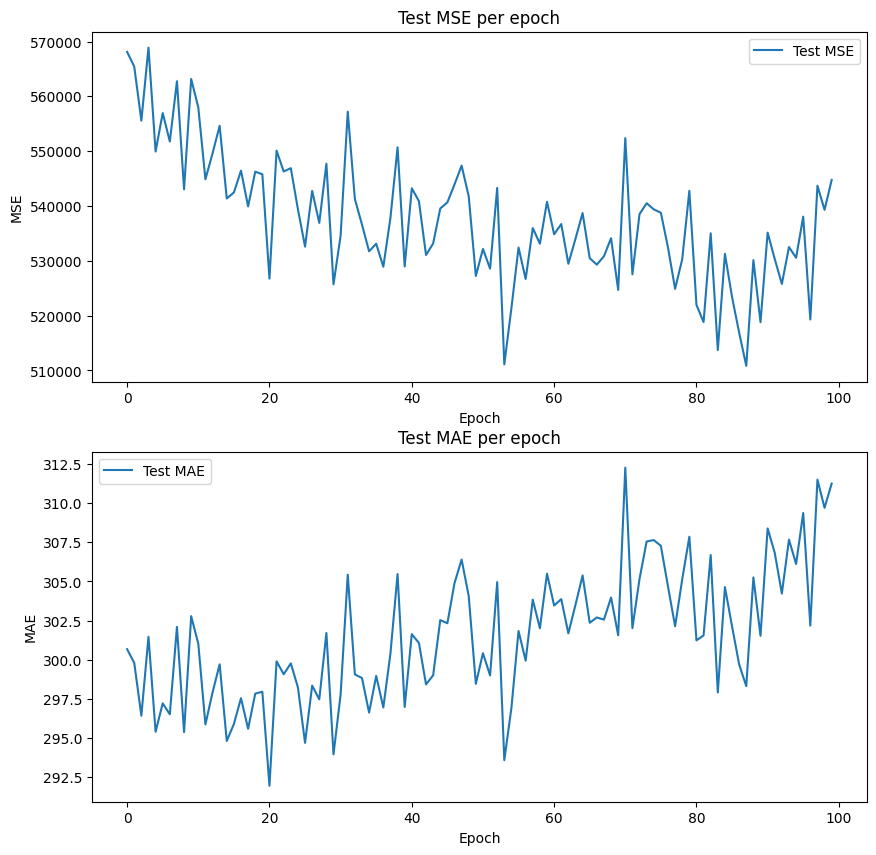

In [33]:
# visualize the test MSE and MAE per epoch in 2 different plots, use axes
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].plot(test_mse_per_epoch, label='Test MSE')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].set_title('Test MSE per epoch')

axes[1].plot(test_mae_per_epoch, label='Test MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].set_title('Test MAE per epoch')

plt.show()

## Visualizing the model's predictions

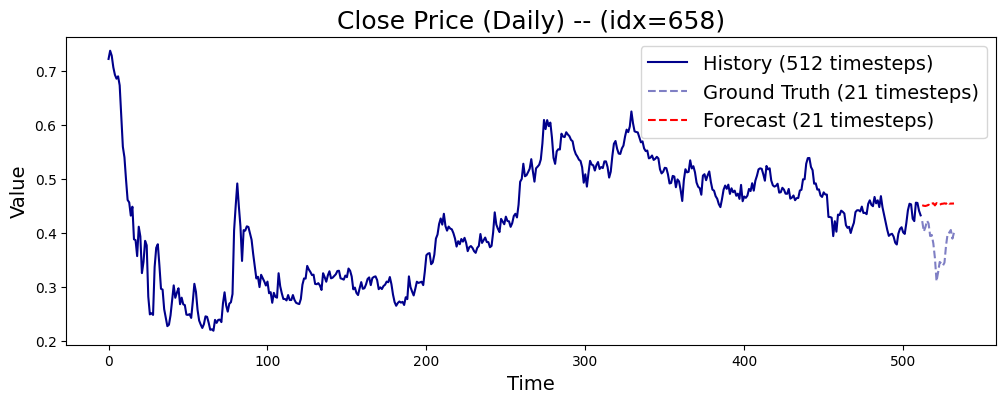

In [42]:
# Assuming histories, trues, and preds are your lists containing the data
# Extracting the first data point

channel_idx = 0
time_index = np.random.randint(0, trues.shape[0]) 

history = histories[time_index, channel_idx, :] 
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

plt.figure(figsize=(12, 4))

# Plotting the first time series from history
plt.plot(range(len(history)), history, label='History (512 timesteps)', c='darkblue')

# Plotting ground truth and prediction
num_forecasts = len(true)

offset = len(history)
plt.plot(range(offset, offset + len(true)), true, label='Ground Truth (21 timesteps)', color='darkblue', linestyle='--', alpha=0.5)
plt.plot(range(offset, offset + len(pred)), pred, label='Forecast (21 timesteps)', color='red', linestyle='--')

plt.title(f"Close Price (Daily) -- (idx={time_index}) MOMENT", fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=14)
plt.show()

## Summary

As this model needs to be pretrained, and our training data is small, it did not succeed in predicting the test data with horizon $H=21$. We assume similar results for other horizon values.

# LSTM

In [79]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.num_layers = num_layers
        self.fc1 = nn.Linear(input_size, self.hidden_size1)
        self.fc2 = nn.Linear(self.hidden_size1, self.hidden_size2)
        self.lstm = nn.LSTM(self.hidden_size2, self.hidden_size2, num_layers, batch_first=True, dropout=dropout)
        self.fc3 = nn.Linear(self.hidden_size2, self.hidden_size1)
        self.fc4 = nn.Linear(self.hidden_size1, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size2).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size2).to(x.device)
        
        # x is of shape (batch_size, input_size, seq_length) but LSTM expects (batch_size, seq_length, input_size)
        x = x.permute(0, 2, 1)
        out = self.fc1(x)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.relu(out)
        out, _ = self.lstm(out, (h0, c0))
        out = out[:, -1, :]
        out = self.fc3(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.fc4(out)

        return out

In [80]:
num_features = len(train_df.columns) -1
print(f"Number of features: {num_features}")

Number of features: 6


In [81]:
hidden_size1 = 128
hidden_size2 = 256
num_layers = 8
output_size = H  # Predicting H points ahead

model = LSTMModel(input_size=num_features, hidden_size1=hidden_size1, hidden_size2=hidden_size2, num_layers=num_layers, output_size=output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
test_mse_per_epoch = []
test_mae_per_epoch = []

for epoch in tqdm(range(num_epochs), total=num_epochs, leave=True):
    model.train()
    losses = []
    for timeseries, forecast, _ in train_loader:
        timeseries, forecast = timeseries.to(device), forecast.to(device)
        forecast_close_price = forecast[:, 0, :]

        outputs = model(timeseries)
        loss = criterion(outputs, forecast_close_price)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    losses = np.array(losses)
    average_loss = np.average(losses)
    #print(f"Epoch {epoch}: Train loss: {average_loss:.3f}")
        
    
    # Evaluate the model on the test loader
    model.eval()
    trues, preds, histories = [], [], []
    for timeseries, forecast, _ in test_loader:
        timeseries, forecast = timeseries.to(device), forecast.to(device)
        forecast_close_price = forecast[:, 0, :]

        outputs = model(timeseries)
        trues.append(forecast_close_price.detach().cpu().numpy())
        preds.append(outputs.detach().cpu().numpy())
        histories.append(timeseries.detach().cpu().numpy())
    
    trues = np.concatenate(trues, axis=0)
    preds = np.concatenate(preds, axis=0)
    histories = np.concatenate(histories, axis=0)
    
    metrics = get_forecasting_metrics(y=trues, y_hat=preds, reduction='mean')

    tqdm.write(f"Epoch {epoch+1}: Train loss: {average_loss:.3f} | Test MSE: {metrics.mse:.3f} | Test MAE: {metrics.mae:.3f}")
    test_mse_per_epoch.append(metrics.mse)
    test_mae_per_epoch.append(metrics.mae)


  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:18<05:45, 18.17s/it]

Epoch 1: Train loss: 0.090 | Test MSE: 0.235 | Test MAE: 0.465


 10%|█         | 2/20 [00:36<05:29, 18.29s/it]

Epoch 2: Train loss: 0.040 | Test MSE: 0.211 | Test MAE: 0.439


 15%|█▌        | 3/20 [00:54<05:11, 18.30s/it]

Epoch 3: Train loss: 0.037 | Test MSE: 0.350 | Test MAE: 0.575


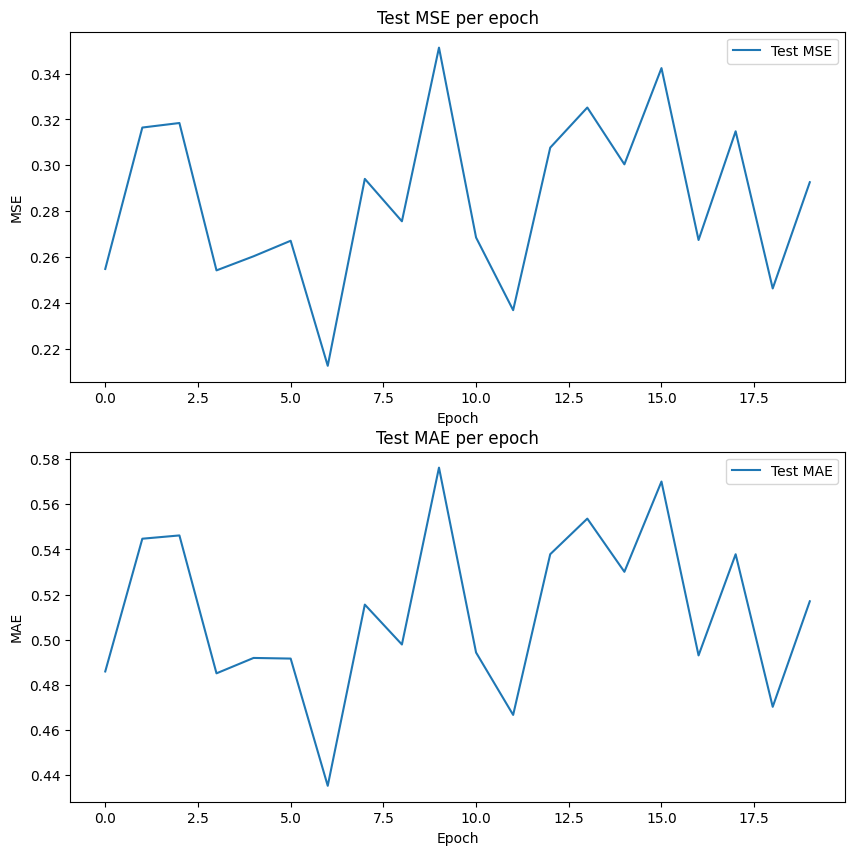

In [ ]:
# visualize the test MSE and MAE per epoch in 2 different plots, use axes
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].plot(test_mse_per_epoch, label='Test MSE')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].set_title('Test MSE per epoch')

axes[1].plot(test_mae_per_epoch, label='Test MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].set_title('Test MAE per epoch')

plt.show()

## Visualizing the model's predictions

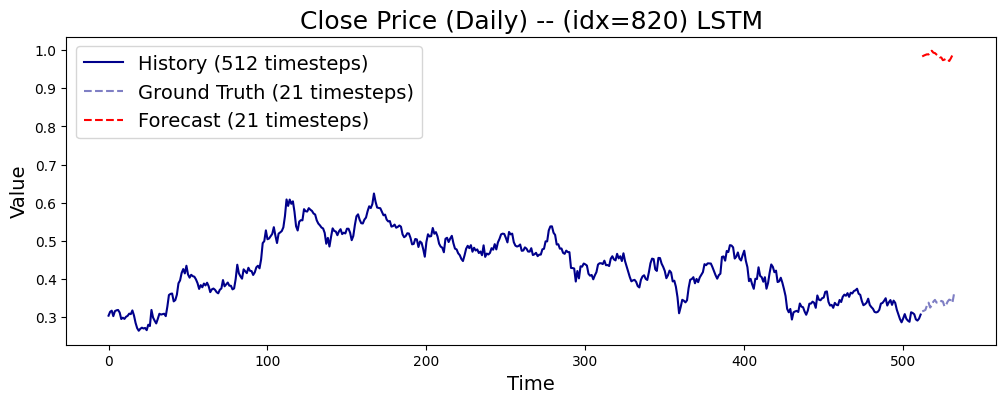

In [ ]:
# Assuming histories, trues, and preds are your lists containing the data
# Extracting the first data point

channel_idx = 0
time_index = np.random.randint(0, trues.shape[0]) 

history = histories[time_index, channel_idx, :] 
true = trues[time_index, :]
pred = preds[time_index, :]

plt.figure(figsize=(12, 4))

# Plotting the first time series from history
plt.plot(range(len(history)), history, label='History (512 timesteps)', c='darkblue')

# Plotting ground truth and prediction
num_forecasts = len(true)

offset = len(history)
plt.plot(range(offset, offset + len(true)), true, label='Ground Truth (21 timesteps)', color='darkblue', linestyle='--', alpha=0.5)
plt.plot(range(offset, offset + len(pred)), pred, label='Forecast (21 timesteps)', color='red', linestyle='--')

plt.title(f"Close Price (Daily) -- (idx={time_index}) LSTM", fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=14)
plt.show()